# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Solución

### Dependencias necesarias


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Lista dónde se guardarán los datos de los precios
preciosDias = []
preciosDeflectados = []

## Procesamiento de datos

Los datos usados son los siguientes: 
<ul>
    <li>Los datos de los precios de energía dados para la realización del laboratorio.</li>
    <li>Los datos correspondientes a los Indices del precio al consumidor, fueron recogidos de la página del Banco de la República de Colombia en un archivo de excel, corresponden a datos corregidos por el DANE. Para el IPC de cada año, se recogió el IPC de cada año en el mes de Enero. Y se guardó en el archivo IPCs_Anuales.csv</li>
</ul>
Los datos anteriormente mencionados se usarán para deflectar los precios, al valor de 2018.

In [23]:
with open("datos/IPCs_Anuales.csv", "rb") as file:
    ipcs = pd.read_csv(file)
    ipcs = ipcs.to_numpy()[:, 1:]
    file.close()

ipcs[:, 1] = ipcs[:, 1] / 100
n = 0
## ==================================================
##          LISTADO DE LOS DATOS
##          Y DEFLACTACIÓN
## ==================================================
for year in range(1995, 2016):
# year = 1995
    with open("datos/precios/Precio_Bolsa_Nacional_($kwh)_"+ str(year) +".xlsx", "rb") as file:

        datos = pd.read_excel(file)
        datosNumpy = datos.to_numpy()
        datosNumpy = np.nan_to_num(datosNumpy)
        file.close()
        # Encontrar el valor "Fecha"
    row, column = np.where(datosNumpy == "Fecha")
    row +=1
    column +=1
    datosNumpy = datosNumpy[row[0]:, column[0]:]
    if year >= 2010:
        datosNumpy = datosNumpy[:, :-2]
    if isinstance(datosNumpy[0, -1], str):
        datosNumpy = datosNumpy[:, :-1]
    for i in range(datosNumpy.shape[0]):
        promedio = sum(datosNumpy[i,:])/ datosNumpy.shape[1]
        preciosDias.append(promedio)
        # Deflectamos los precios
        promedio = promedio * (ipcs[-1, 1] / ipcs[n, 1])
        preciosDeflectados.append(promedio)
    n += 1
for year in range(2016, 2019):
    with open("datos/precios/Precio_Bolsa_Nacional_($kwh)_" + str(year) + ".xls", "rb") as file:
        datos = pd.read_excel(file)
        datosNumpy = datos.to_numpy()
        datosNumpy = np.nan_to_num(datosNumpy)
        file.close()
    row, column = np.where(datosNumpy == "Fecha")
    row += 1
    column += 1
    datosNumpy = datosNumpy[row[0]: , column[0]:]
    datosNumpy = datosNumpy[:, :-2]
    
    for i in range(datosNumpy.shape[0]):
        promedio = sum(datosNumpy[i, :]) / datosNumpy.shape[1]
        preciosDias.append(promedio)
        # Precios deflectados
        promedio = promedio * (ipcs[-1, 1] / ipcs[n, 1])
        preciosDeflectados.append(promedio)
    n+=1
preciosDeflectados = np.nan_to_num(np.array(preciosDeflectados))

                                           

### Gráfica de los datos procesados

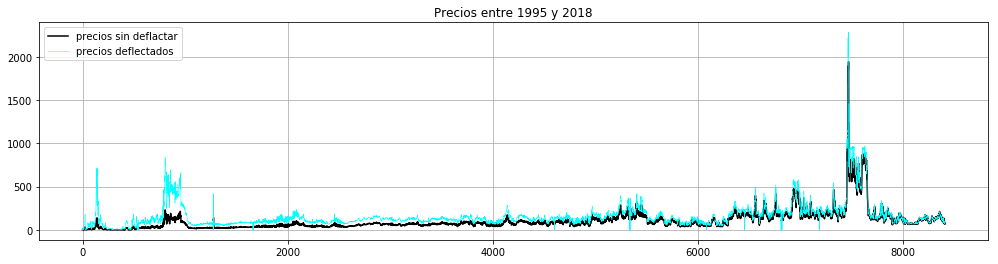

In [24]:
## ========================================
##         GRÁFICA PRECIOS DEFLECTADOS
## ========================================
plt.figure(figsize = (17, 4))
plt.title("Precios entre 1995 y 2018")
plt.plot([dia for dia in range(len(preciosDias))], preciosDias, color= 'black', label = "precios sin deflactar")
plt.plot([dia for dia in range(len(preciosDeflectados))], preciosDeflectados, linewidth = 0.5, color = 'cyan', label = "precios deflectados")
plt.grid(True)
plt.legend()

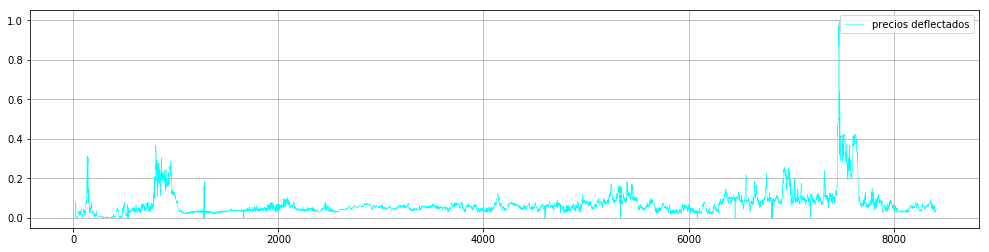

In [25]:
# preciosDeflectados1 = np.log(preciosDeflectados)
# # preciosDeflectados1 = np.add(preciosDeflectados ** (1/2), 25)
# preciosDeflectados = preciosDeflectados /np.sqrt(preciosDeflectados)
precio_maximo = max(preciosDeflectados)
preciosDeflectados /= precio_maximo
plt.figure(figsize = (17, 4))
plt.plot([dia for dia in range(len(preciosDeflectados))], preciosDeflectados, linewidth = 0.5, color = 'cyan', label = "precios deflectados")
plt.grid(True)
plt.legend()

### Implementación de Adaline en tensorflow


In [26]:
import tensorflow as tf

class Model(object):
    
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L))
        
    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype = np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred
    
    def fit(self, mu, x, y_desired):
        
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype = np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))
        



# Prueba del modelo.
Con el preprocesamiento de los datos realizados, y con el modelo implementado, se va a probar el modelo, con un tasa de aprendizaje de 0.05. 
Luego se mostrará la búsqueda óptima de esta tasa, y los retardos óptimos

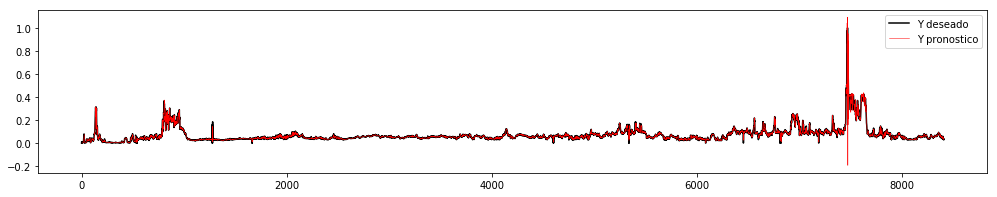

In [63]:
L = 6

model = Model (L)

y_pred = np.empty(len(preciosDeflectados))
y_pred[:] = np.nan

for t in range(L, len(preciosDeflectados)):
    x = preciosDeflectados[t-L: t]
    y_pred[t] = model(x)
    model.fit(mu = 0.051000000000000004, x = x, y_desired = preciosDeflectados[t])
    
plt.figure(figsize = (17, 3))
plt.plot(preciosDeflectados, color = 'black', label = "Y deseado")
plt.plot(y_pred, color = 'red', linewidth = 0.5, label = "Y pronostico" )
plt.legend()

### Definiciones de las funciones necesarias para encontrar los retardos y el momentum óptimo.

In [59]:

def evalModelo(delay, mu):
    
    m = Model (delay)
    auxiliar = []
    y_pred = np.zeros(len(preciosDeflectados))
    
    for t in range(delay, len(preciosDeflectados)):
        x = preciosDeflectados[t-delay: t]
        y_pred[t]  = m(x)
        m.fit(mu, x, preciosDeflectados[t])
    sse = sum ((preciosDeflectados[-7:] - y_pred[-7:]) ** 2)
    print("SSE: ", sse)
    return sse

def search_delay(retrasos, mu):
    minimo = -1
    opt = retrasos [0]
    for retraso in retrasos:
        sse = evalModelo(retraso, mu)
        if minimo == -1:
            minimo = sse
            continue
        if sse < minimo:
            minimo = sse
            opt = retraso
    return opt

def search_mu(delay, mus):
    minimo = -1
    opt = mus[0]
    for mu in mus:
        sse = evalModelo(delay, mu)
        if minimo == -1:
            minimo = sse
            continue
        if sse < minimo:
            minimo = sse
            opt = mu
    return opt

retrasos = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Retraso optimo
retOpt = search_delay(retrasos, 0.05)
print("El retraso óptimo con un mu = 0.05 es:\t", retOpt)

SSE:  0.0006008692731765732
SSE:  0.0004060210794594518
SSE:  0.00031934056414723586
SSE:  0.00028188554803273866
SSE:  0.0002746353051372087
SSE:  0.0002829969490745213
SSE:  0.0003305991973915043
SSE:  0.007579751289943613
SSE:  17.527027259830557
El retraso óptimo con un mu = 0.05 es:	 6


### Lo anterior indica que el retraso óptimo es 8. Lo siguiente es buscar el mu óptimo.

In [74]:
momentus = [0.001* n for n in range(100)]

opt = search_mu(6, momentus)
print("La tasa de aprendizaje óptimo es:\t", opt)

SSE:  0.007678377562891471
SSE:  0.004104109558312239
SSE:  0.0037718260446877394
SSE:  0.0030264348453459718
SSE:  0.0023905650532970563
SSE:  0.0019248925632561716
SSE:  0.0015952030696158054
SSE:  0.0013597864518283534
SSE:  0.0011872764721218797
SSE:  0.0010567357786723636
SSE:  0.0009546847439848511
SSE:  0.0008724864298977083
SSE:  0.000804553309189887
SSE:  0.0007472051866735697
SSE:  0.0006979621823268682
SSE:  0.0006551048274794582
SSE:  0.000617410948710001
SSE:  0.0005839825337465931
SSE:  0.0005541419876357985
SSE:  0.0005273650552699384
SSE:  0.0005032350465726714
SSE:  0.0004814145999703468
SSE:  0.0004616265533916053
SSE:  0.00044363745104716314
SSE:  0.00042725160151963154
SSE:  0.0004123005612158116
SSE:  0.00039863980689993614
SSE:  0.0003861444104879337
SSE:  0.0003747048212543113
SSE:  0.0003642259233565013
SSE:  0.00035462343640465464
SSE:  0.00034582354234537926
SSE:  0.0003377603269622812
SSE:  0.00033037615280955967
SSE:  0.00032361879159342266
SSE:  0.000317442

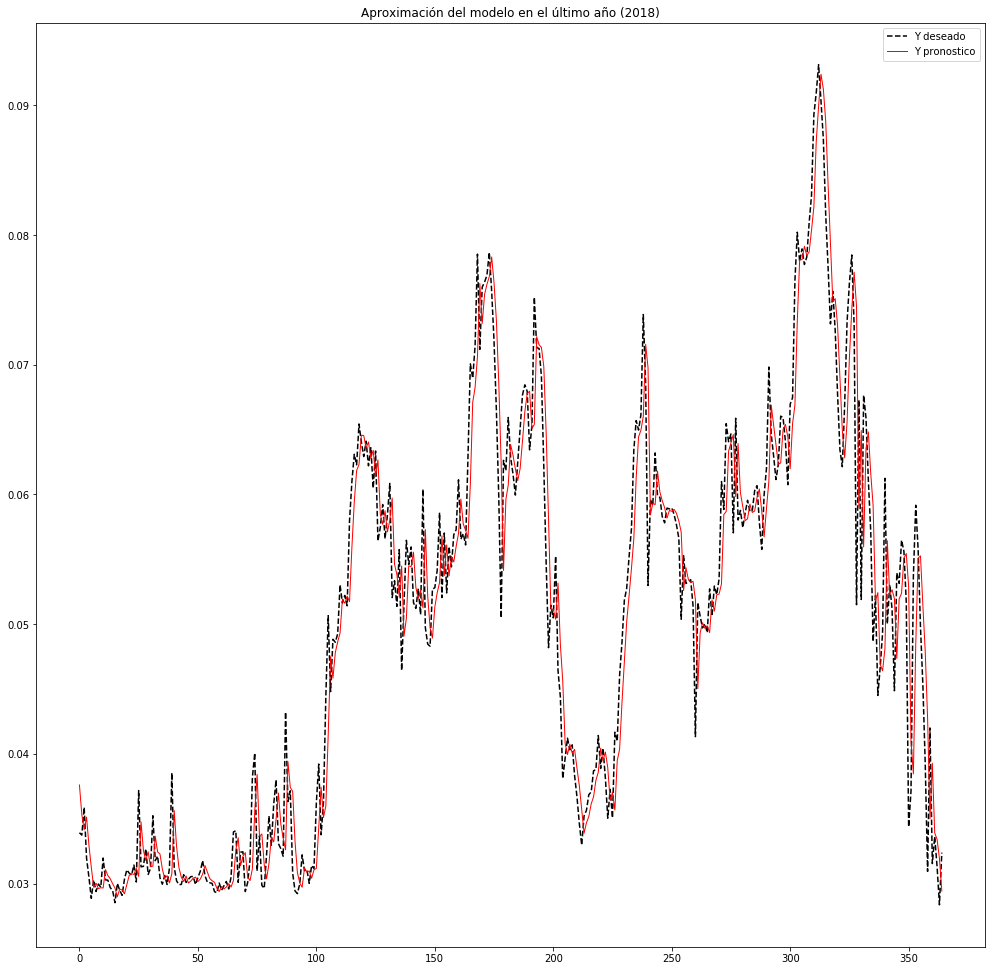

In [73]:
mu = 0.051000000000000004
L = 6
y_pred = np.empty(len(preciosDeflectados))
y_pred[:] = np.nan
model = Model(L)
for t in range(L, len(preciosDeflectados)):
    x = preciosDeflectados[t-L: t]
    y_pred[t] = model(x)
    model.fit(mu , x, y_desired = preciosDeflectados[t])
    
plt.figure(figsize = (17, 17))
plt.plot(preciosDeflectados[-365:], '--', color = 'black', label = "Y deseado")
plt.plot(y_pred[-365:], color = 'red', linewidth = 1.0, label = "Y pronostico" )
plt.title("Aproximación del modelo en el último año (2018)")
plt.legend()

### Análisis de transformaciones en el modelo.
Usando la tasa de aprendizaje, y el retraso encontrados para el Modelo Adaline. Se procederá a analizar las siguientes transformaciones para ver si hay una mejora para la aproximación del modelo.


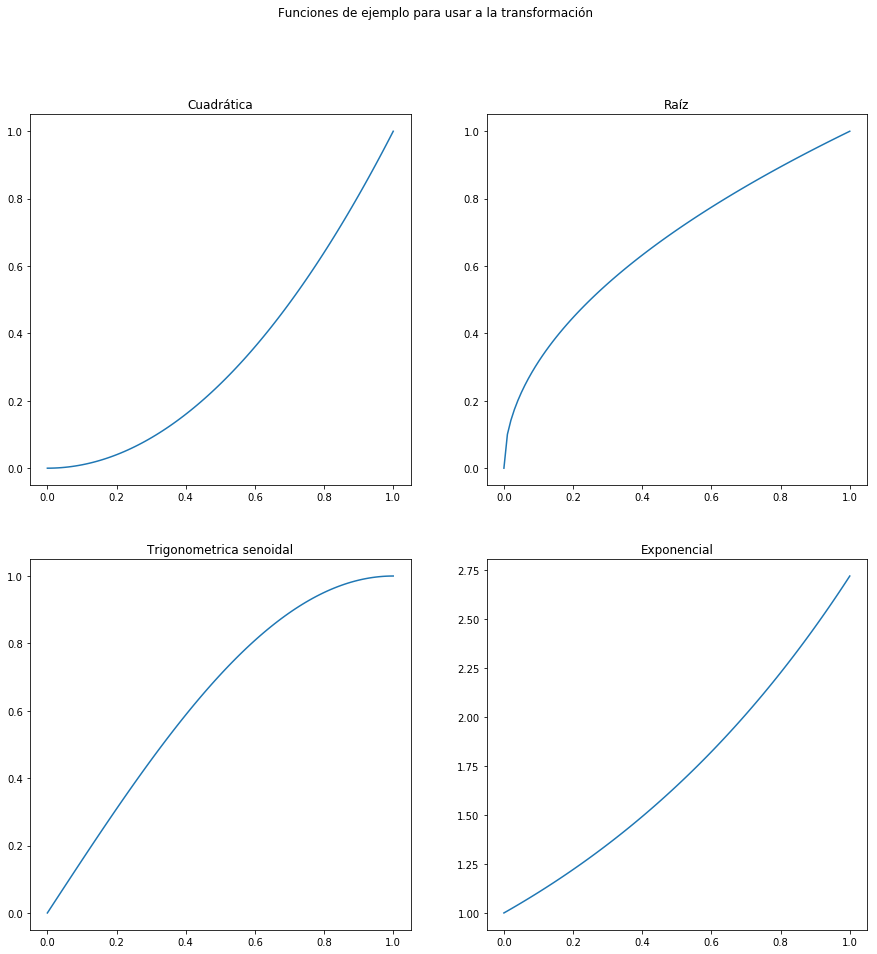

In [105]:
x = np.linspace(0.0, 1.0, 100)

y1 = x ** 2
y2 = x ** (1/2)
y3 = np.sin(x/ 2*np.pi)
y4 = np.exp(x)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))

fig.suptitle("Funciones de ejemplo para usar a la transformación")
ax1.set_title("Cuadrática")
ax1.plot(x, y1)
ax2.set_title("Raíz")
ax2.plot(x, y2)
ax3.set_title("Trigonometrica senoidal")
ax3.plot(x, y3)
ax4.set_title("Exponencial")
ax4.plot(x, y4)


Se probarán las anteriores funciones sobre los datos para el entrenamiento del modelo, para así poder ver qué transformación puede brindar mayor precisión.

# Cuadrática

SSE:  1.495997421538354e-06


C:\Users\key14\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


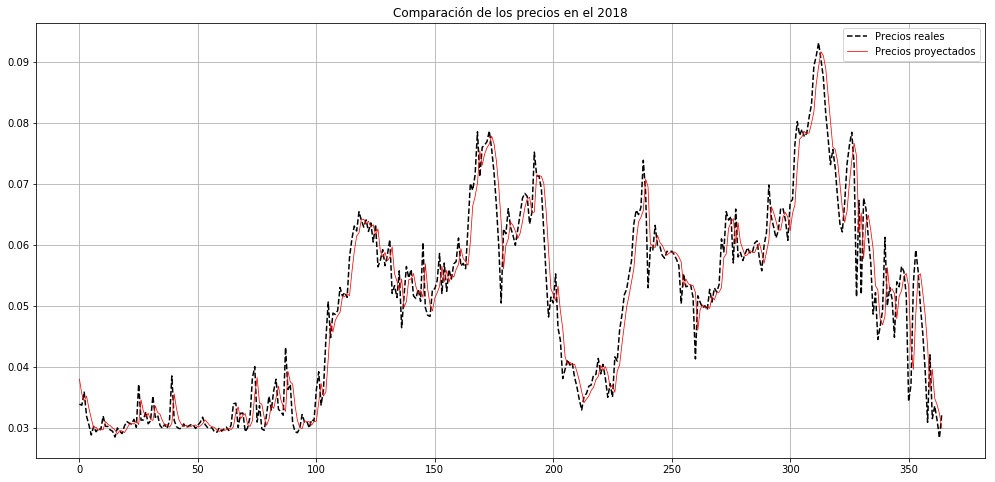

In [113]:
mu = 0.051000000000000004
L = 6

def evalModelo(delay, mu, d):
    
    m = Model (delay)
    auxiliar = []
    y_pred = np.zeros(len(d))
    
    for t in range(delay, len(d)):
        x = d[t-delay: t]
        y_pred[t]  = m(x)
        m.fit(mu, x, d[t])
    sse = sum ((d[-7:] - y_pred[-7:]) ** 2)
    print("SSE: ", sse)
    return y_pred, sse

# Transformación
d_cuad = np.power(preciosDeflectados, 2)

y_pred, sse1 = evalModelo(L, mu, d_cuad)
# Inversión
d_inv1 = y_pred ** (1/2)


plt.figure(figsize = (17, 8))
plt.title("Comparación de los precios en el 2018")
plt.plot(preciosDeflectados[-365:], '--', color = 'black', label="Precios reales")
plt.plot(d_inv1[-365:], color = 'red', linewidth = 0.75, label = "Precios proyectados")
plt.legend()
plt.grid(True)


# Raíz cuadrada

SSE:  0.0020226902388600374


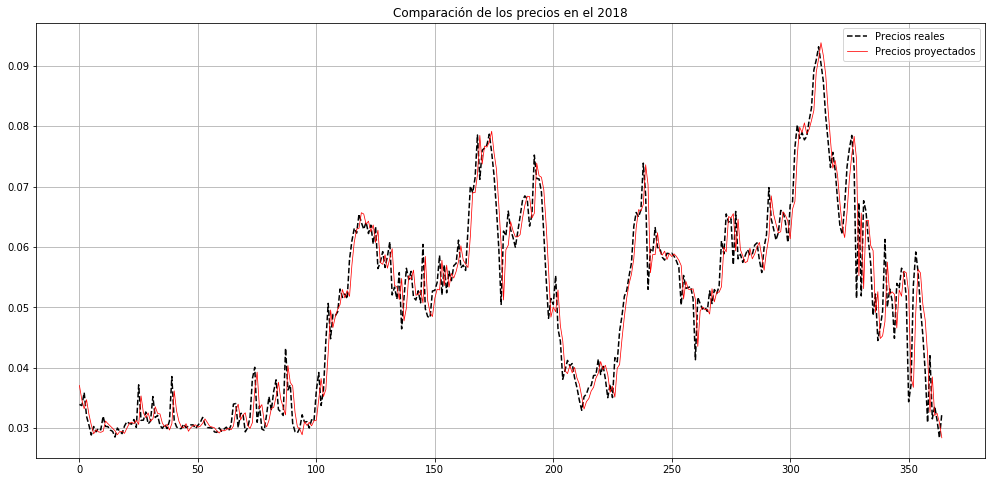

In [114]:
# Transformacion
d_sqrt = preciosDeflectados ** (1/2)

y_pred, sse2 = evalModelo(L, mu, d_sqrt)
# Inversión
d_inv2 = y_pred ** 2

plt.figure(figsize = (17, 8))
plt.title("Comparación de los precios en el 2018")
plt.plot(preciosDeflectados[-365:], '--', color = 'black', label="Precios reales")
plt.plot(d_inv2[-365:], color = 'red', linewidth = 0.75, label = "Precios proyectados")
plt.legend()
plt.grid(True)


# Senoidal


SSE:  0.00027265708926217354


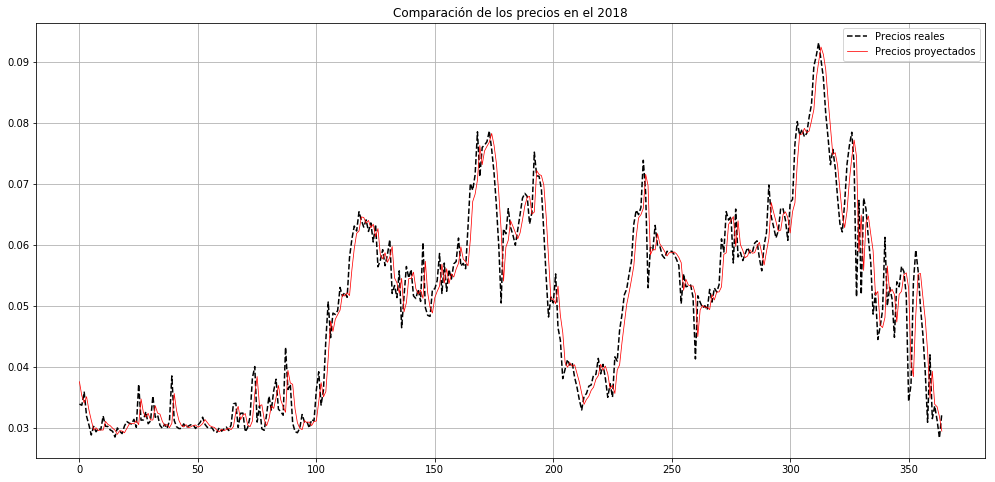

In [115]:
# Transformacion
d_sin = np.sin(preciosDeflectados) 

y_pred, sse3 = evalModelo(L, mu, d_sin)
# Inversión
d_inv3 = np.arcsin(y_pred)


plt.figure(figsize = (17, 8))
plt.title("Comparación de los precios en el 2018")
plt.plot(preciosDeflectados[-365:], '--', color = 'black', label="Precios reales")
plt.plot(d_inv3[-365:], color = 'red', linewidth = 0.75, label = "Precios proyectados")
plt.legend()
plt.grid(True)

# Exponencial


C:\Users\key14\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


SSE:  nan


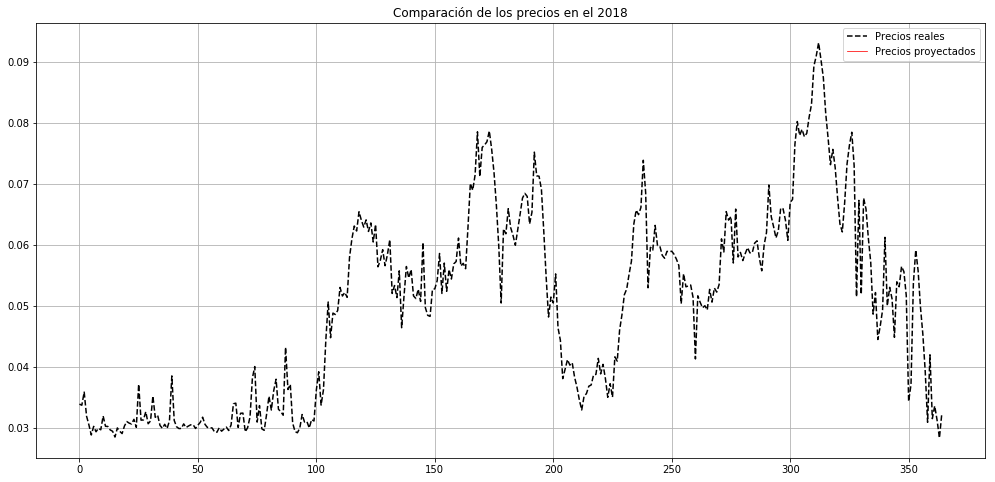

In [118]:
# Transformacion
d_ln = np.log(preciosDeflectados) 

y_pred, sse4 = evalModelo(L, mu, d_ln)
# Inversión
d_inv4 = np.exp(y_pred)


plt.figure(figsize = (17, 8))
plt.title("Comparación de los precios en el 2018")
plt.plot(preciosDeflectados[-365:], '--', color = 'black', label="Precios reales")
plt.plot(d_inv4[-365:], color = 'red', linewidth = 0.75, label = "Precios proyectados")
plt.legend()
plt.grid(True)

Para un mejor análisis gráfico se procederá a mirar el comportamiento de los anteriores transformaciones en los últimos 15 días pronosticados.

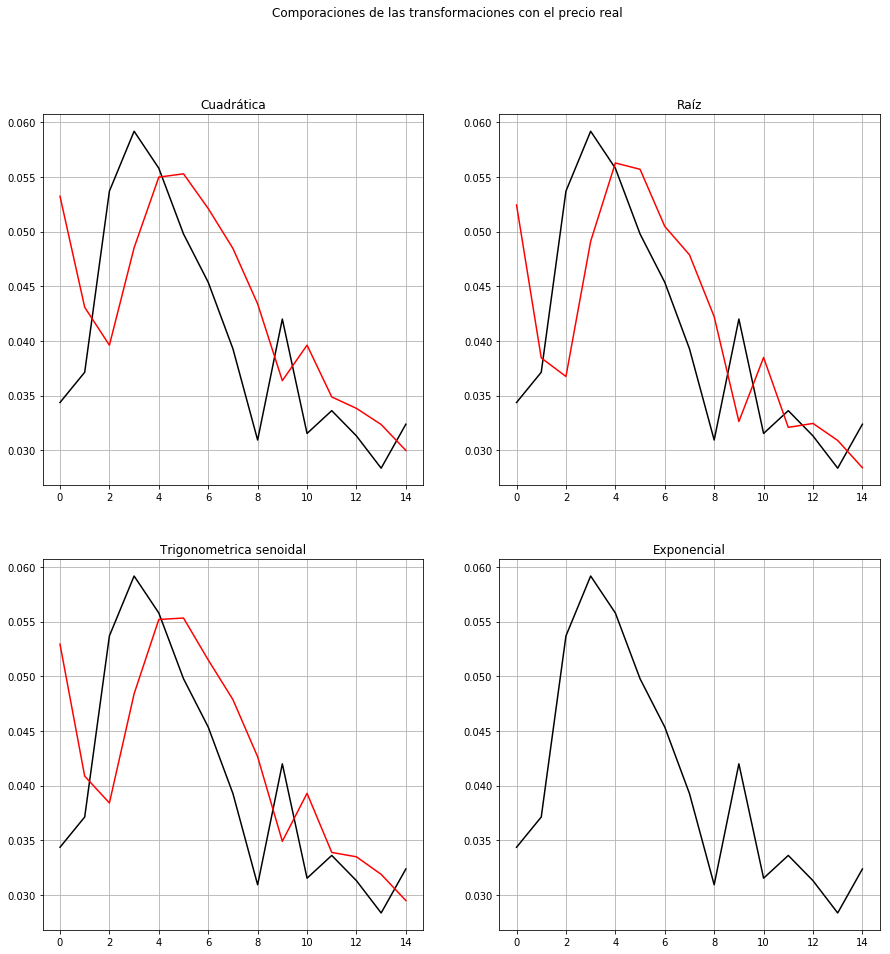

In [117]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))

fig.suptitle("Comporaciones de las transformaciones con el precio real")

ax1.set_title("Cuadrática")
ax1.plot(preciosDeflectados[-15:],color = 'black')
ax1.plot(d_inv1[-15:], color = 'red')
ax1.grid(True)

ax2.set_title("Raíz")
ax2.plot(preciosDeflectados[-15:],color = 'black')
ax2.plot(d_inv2[-15:], color = 'red')
ax2.grid(True)

ax3.set_title("Trigonometrica senoidal")
ax3.plot(preciosDeflectados[-15:],color = 'black')
ax3.plot(d_inv3[-15:], color = 'red')
ax3.grid(True)


ax4.set_title("Exponencial")
ax4.plot(preciosDeflectados[-15:],color = 'black')
ax4.plot(d_inv4[-15:], color = 'red')
ax4.grid(True)


SSE:  0.00027446051012173546


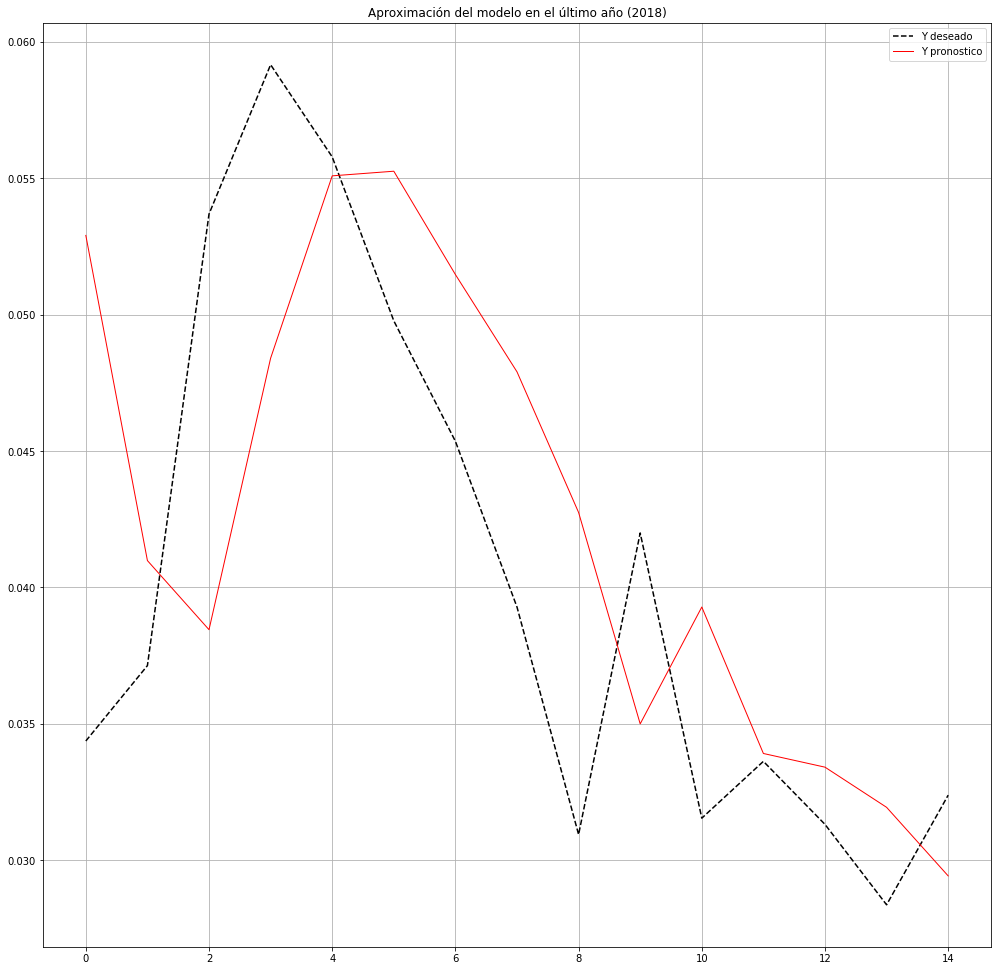

In [112]:
y_pred, sse5 = evalModelo(L, mu, preciosDeflectados)

plt.figure(figsize = (17, 17))
plt.plot(preciosDeflectados[-15:], '--', color = 'black', label = "Y deseado")
plt.plot(y_pred[-15:], color = 'red', linewidth = 1.0, label = "Y pronostico" )
plt.title("Aproximación del modelo en el último año (2018)")
plt.grid(True)
plt.legend()

Si nos guiamos por el la Suma de Errores Cuadráticos, podemos decir que una mejor transformación para modelar el comportamiento de los precios es la transformación cuádratica, que tiene un menor SSE que las otras transformaciones, e incluso es menor que los datos sin transformar. 
Aún así, gráficamente parece ser que todas las tranformaciones son buenas.

# Pronóstico diario 7 días.

Primero se realizará una pruba usando los datos de entrenamiento de los últimos 7 días correspondientes a los datos brindados. Y finalmente se hará el pronóstico en los siguientes 7 días.

Evaluacion sin transfomación
SSE:  0.00026801745705201023
con transformación cuadrática
SSE:  1.4688607679912728e-06


C:\Users\key14\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


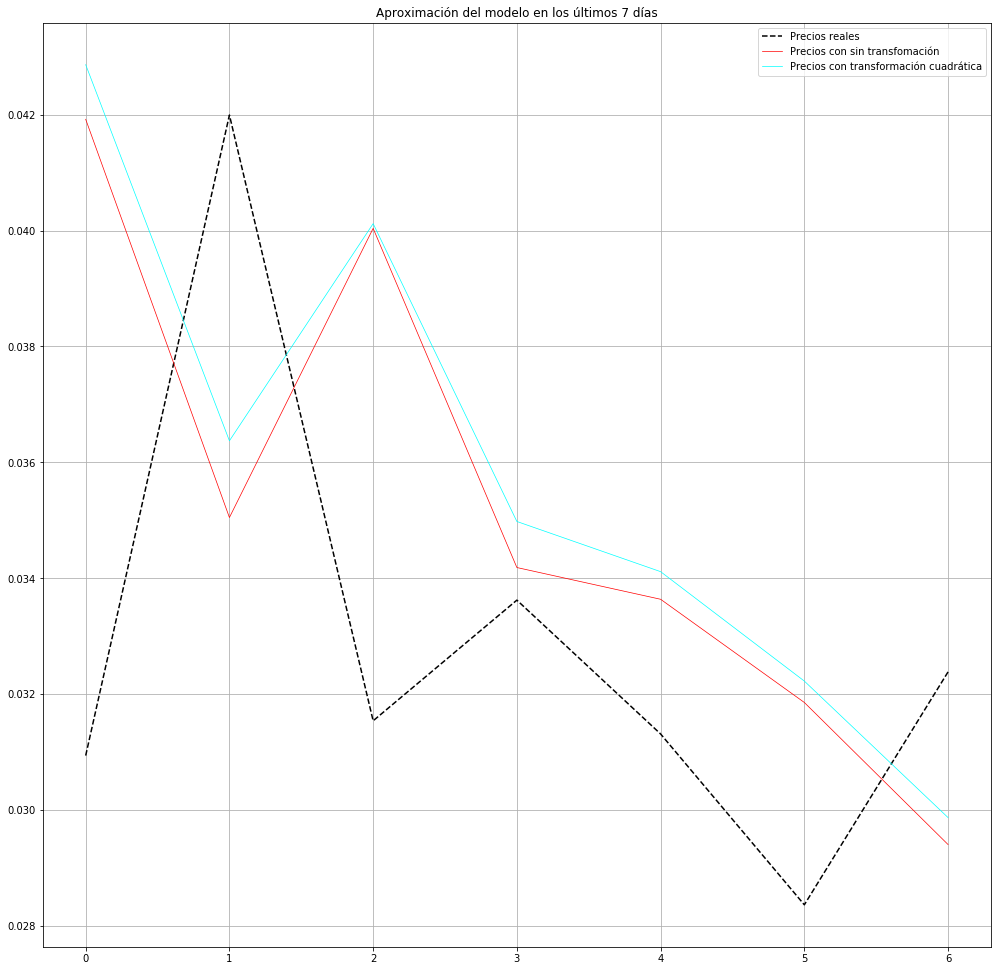

In [125]:
days = 7

def evalModelo(delay, mu, d, days):
    
    m = Model (delay)
    auxiliar = []
    y_pred = np.zeros(len(d))
    
    for t in range(delay, len(d)):
        
        # Se hará el pronostico a partir de los datos modelados por ADALINE
        if t >= len(d) - days:
            x = y_pred[t-delay: t]
            y_pred[t] = m(x)
            m.fit(mu, x, d[t])
            continue
        x = d[t-delay: t]
        y_pred[t]  = m(x)
        m.fit(mu, x, d[t])
        
    sse = sum ((d[-7:] - y_pred[-7:]) ** 2)
    print("SSE: ", sse)
    return y_pred, sse

print("Evaluacion sin transfomación")
y_pred, sse = evalModelo(L, mu, preciosDeflectados, days)

# Transformación
d_cuad = np.power(preciosDeflectados, 2)
print("con transformación cuadrática")
y_predicted, sse1 = evalModelo(L, mu, d_cuad, days)
# Inversión
d_inv1 = y_predicted ** (1/2)

plt.figure(figsize = (17, 17))
plt.plot(preciosDeflectados[-7:], '--', color = 'black', label = "Precios reales")
plt.plot(y_pred[-7:], color = 'red', linewidth = 0.7, label = "Precios con sin transfomación")
plt.plot(d_inv1[-7:], color = 'cyan', linewidth = 0.7, label = "Precios con transformación cuadrática")
plt.title("Aproximación del modelo en los últimos 7 días")
plt.grid(True)
plt.legend()